In [1]:
# Copy dataset from Drive to local content directory
!cp -r /content/drive/MyDrive/dakshina_dataset_v1.0 /content/

In [25]:
!apt-get -y install fonts-noto

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra
  fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji
  fonts-noto-core fonts-noto-extra fonts-noto-mono fonts-noto-ui-core
  fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 34 not upgraded.
Need to get 317 MB of archives.
After this operation, 790 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd
import numpy as np
import wandb
import os
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [3]:
# Choose your language
LANG = 'hi'  # Hindi
DATA_DIR = f'/content/dakshina_dataset_v1.0/{LANG}/lexicons/'

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    input_texts, target_texts = [], []
    for line in lines:
        latin, devanagari = line.strip().split('\t')[:2]
        input_texts.append(list(latin.lower()))
        target_texts.append(['<sos>'] + list(devanagari) + ['<eos>'])
    return input_texts, target_texts

train_x, train_y = load_data(os.path.join(DATA_DIR, 'hi.translit.sampled.train.tsv'))
val_x, val_y = load_data(os.path.join(DATA_DIR, 'hi.translit.sampled.dev.tsv'))
test_x, test_y = load_data(os.path.join(DATA_DIR, 'hi.translit.sampled.test.tsv'))

# Create vocab
def build_vocab(seqs):
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
    for seq in seqs:
        for ch in seq:
            if ch not in vocab:
                vocab[ch] = len(vocab)
    return vocab

src_vocab = build_vocab(train_x)
tgt_vocab = build_vocab(train_y)

inv_tgt_vocab = {v: k for k, v in tgt_vocab.items()}
# Special token indices
PAD_IDX = tgt_vocab['<pad>']
SOS_IDX = tgt_vocab['<sos>']
EOS_IDX = tgt_vocab['<eos>']


In [4]:
src_vocab

{'<pad>': 0,
 '<sos>': 1,
 '<eos>': 2,
 'a': 3,
 'n': 4,
 'k': 5,
 'g': 6,
 'i': 7,
 't': 8,
 'u': 9,
 'c': 10,
 'l': 11,
 'e': 12,
 'r': 13,
 's': 14,
 'h': 15,
 'd': 16,
 'b': 17,
 'y': 18,
 'o': 19,
 'j': 20,
 'z': 21,
 'm': 22,
 'v': 23,
 'w': 24,
 'p': 25,
 'f': 26,
 'x': 27,
 'q': 28}

In [5]:
tgt_vocab

{'<pad>': 0,
 '<sos>': 1,
 '<eos>': 2,
 'अ': 3,
 'ं': 4,
 'क': 5,
 'ग': 6,
 'ण': 7,
 'ि': 8,
 'त': 9,
 'ल': 10,
 'ु': 11,
 'र': 12,
 'श': 13,
 'द': 14,
 'न': 15,
 'े': 16,
 'भ': 17,
 '्': 18,
 'ष': 19,
 'ा': 20,
 'ी': 21,
 'ठ': 22,
 'य': 23,
 'ो': 24,
 'ू': 25,
 'ज': 26,
 'च': 27,
 'म': 28,
 'ट': 29,
 'ड': 30,
 'व': 31,
 'ः': 32,
 'ह': 33,
 'प': 34,
 'ृ': 35,
 'स': 36,
 'ध': 37,
 'ै': 38,
 '़': 39,
 'ब': 40,
 'उ': 41,
 'ॉ': 42,
 'ई': 43,
 'ख': 44,
 'घ': 45,
 'छ': 46,
 'ञ': 47,
 'फ': 48,
 'ओ': 49,
 'थ': 50,
 'ढ': 51,
 'झ': 52,
 'ौ': 53,
 'आ': 54,
 'इ': 55,
 'ँ': 56,
 'ए': 57,
 'ऊ': 58,
 'ॅ': 59,
 'ऋ': 60,
 'ऑ': 61,
 'ऐ': 62,
 'औ': 63,
 'ङ': 64,
 'ॐ': 65}

In [6]:
class TransliterationDataset(Dataset):
    def __init__(self, src_data, tgt_data, src_vocab, tgt_vocab):
        self.src_data = src_data
        self.tgt_data = tgt_data
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_seq = [self.src_vocab[ch] for ch in self.src_data[idx]]
        tgt_seq = [self.tgt_vocab[ch] for ch in self.tgt_data[idx]]
        return torch.tensor(src_seq), torch.tensor(tgt_seq)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_lens = torch.tensor([len(s) for s in src_batch])
    tgt_lens = torch.tensor([len(t) for t in tgt_batch])
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_batch, tgt_batch, src_lens, tgt_lens

BATCH_SIZE = 64
train_dataset = TransliterationDataset(train_x, train_y, src_vocab, tgt_vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataset = TransliterationDataset(val_x, val_y, src_vocab, tgt_vocab)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
# Prepare test loader
test_dataset = TransliterationDataset(test_x, test_y, src_vocab, tgt_vocab)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Seq2Seq(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder_embed = nn.Embedding(config['src_vocab_size'], config['embedding_size'])
        self.decoder_embed = nn.Embedding(config['tgt_vocab_size'], config['embedding_size'])

        cell = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[config['cell_type']]

        self.encoder = cell(config['embedding_size'], config['hidden_size'], config['num_encoder_layers'],
                            batch_first=True, dropout=config['dropout'] if config['num_encoder_layers'] > 1 else 0)

        self.decoder = cell(config['embedding_size'], config['hidden_size'], config['num_decoder_layers'],
                            batch_first=True, dropout=config['dropout'] if config['num_decoder_layers'] > 1 else 0)

        self.fc = nn.Linear(config['hidden_size'], config['tgt_vocab_size'])

        self.cell_type = config['cell_type']
        self.config = config

    def forward(self, src, tgt, src_len, tgt_len):
        src_embed = self.encoder_embed(src)
        tgt_embed = self.decoder_embed(tgt[:, :-1])

        _, h = self.encoder(src_embed)

        if self.cell_type == 'LSTM':
            h0, c0 = h
            output, _ = self.decoder(tgt_embed, (h0, c0))
        else:
            output, _ = self.decoder(tgt_embed, h)

        logits = self.fc(output)
        return logits

    def beam_search_decode(self, src, src_len, beam_size, sos_idx, eos_idx, max_len=30, device='cpu'):
      src_embed = self.encoder_embed(src)
      _, h = self.encoder(src_embed)

      if self.cell_type == 'LSTM':
        h_n, c_n = h
        h = (h_n, c_n)  # Don't repeat!
      else:
        h = h  # Don't repeat!

      # Initial sequences: list of (tokens, log_prob, hidden)
      sequences = [[[], 0.0, h]]

      for _ in range(max_len):
          all_candidates = []

          for seq, score, h in sequences:
              if len(seq) > 0 and seq[-1] == eos_idx:
                  all_candidates.append((seq, score, h))
                  continue

              input_token = torch.tensor([[sos_idx if len(seq) == 0 else seq[-1]]], device=device)
              embed = self.decoder_embed(input_token)

              if self.cell_type == 'LSTM':
                  output, h_new = self.decoder(embed, h)
              else:
                  output, h_new = self.decoder(embed, h)

              logits = self.fc(output.squeeze(1))
              log_probs = F.log_softmax(logits, dim=-1)

              top_log_probs, top_idx = torch.topk(log_probs[0], beam_size)

              for i in range(beam_size):
                  token = top_idx[i].item()
                  prob = top_log_probs[i].item()

                  # Detach hidden state to prevent backprop through old graph
                  if self.cell_type == 'LSTM':
                      h_candidate = (h_new[0].clone(), h_new[1].clone())
                  else:
                      h_candidate = h_new.clone()

                  all_candidates.append((seq + [token], score + prob, h_candidate))

          sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_size]

      return sequences[0][0]  # best sequence


In [9]:
best_config = {
    'embedding_size': 64,
    'hidden_size': 256,
    'num_encoder_layers': 3,
    'num_decoder_layers': 3,
    'cell_type': 'GRU',
    'dropout': 0.2,
    'src_vocab_size': len(src_vocab),
    'tgt_vocab_size': len(tgt_vocab),
}

In [9]:
model = Seq2Seq(best_config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
PAD_IDX = 0
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_tokens = 0
    correct_tokens = 0

    for src, tgt, src_len, tgt_len in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(src, tgt, src_len, tgt_len)  # shape: (batch, tgt_len-1, vocab_size)
        output = output.reshape(-1, output.shape[-1])  # (batch * tgt_len-1, vocab_size)
        target = tgt[:, 1:].reshape(-1)  # remove SOS, (batch * tgt_len-1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy computation (ignore PAD)
        pred_tokens = output.argmax(dim=-1)  # (batch * tgt_len-1)
        mask = target != PAD_IDX
        correct = (pred_tokens == target) & mask

        correct_tokens += correct.sum().item()
        total_tokens += mask.sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_tokens / total_tokens * 100

    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Train Accuracy = {accuracy:.2f}%")

torch.save(model.state_dict(), "best_model.pth")

Epoch 1: Train Loss = 1.6066, Train Accuracy = 55.64%
Epoch 2: Train Loss = 0.5641, Train Accuracy = 82.44%
Epoch 3: Train Loss = 0.4178, Train Accuracy = 86.74%
Epoch 4: Train Loss = 0.3433, Train Accuracy = 89.01%
Epoch 5: Train Loss = 0.2957, Train Accuracy = 90.45%
Epoch 6: Train Loss = 0.2572, Train Accuracy = 91.64%
Epoch 7: Train Loss = 0.2326, Train Accuracy = 92.40%
Epoch 8: Train Loss = 0.2107, Train Accuracy = 93.05%
Epoch 9: Train Loss = 0.1947, Train Accuracy = 93.55%
Epoch 10: Train Loss = 0.1808, Train Accuracy = 93.94%


In [10]:
model = Seq2Seq(best_config).to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

Seq2Seq(
  (encoder_embed): Embedding(29, 64)
  (decoder_embed): Embedding(66, 64)
  (encoder): GRU(64, 256, num_layers=3, batch_first=True, dropout=0.2)
  (decoder): GRU(64, 256, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=66, bias=True)
)

In [11]:
inv_src_vocab = {v: k for k, v in src_vocab.items()} #Convert set of numbers back to characters
inv_tgt_vocab = {v: k for k, v in tgt_vocab.items()}

In [12]:
def evaluate_beam(model, loader, beam_size, sos_idx, eos_idx):
    correct = 0
    total = 0
    for src, tgt, src_len, tgt_len in loader:
        src = src.to(device)
        pred_ids = model.beam_search_decode(src, src_len, beam_size, sos_idx, eos_idx, device=device)
        pred_str = ''.join([inv_tgt_vocab[i] for i in pred_ids if i not in [sos_idx, eos_idx, PAD_IDX]])
        tgt_str = ''.join([inv_tgt_vocab[i.item()] for i in tgt[0][1:tgt_len.item()-1]])

        if pred_str == tgt_str:
            correct += 1
        total += 1
    return correct / total

In [14]:
beam_sizes = [1, 3, 5]
for b in beam_sizes:
    acc = evaluate_beam(model, test_loader, beam_size=b, sos_idx=SOS_IDX, eos_idx=EOS_IDX)
    print(f"Beam size {b} → Test Accuracy: {acc*100:.2f}%")


Beam size 1 → Test Accuracy: 35.41%
Beam size 3 → Test Accuracy: 36.52%
Beam size 5 → Test Accuracy: 36.52%


In [13]:
import os
import pandas as pd

os.makedirs('predictions_vanilla', exist_ok=True)

def save_all_predictions(model, test_loader, sos_idx, eos_idx, file_path='predictions_vanilla/predictions.csv'):
    predictions = []

    for src, tgt, src_len, tgt_len in test_loader:
        src = src.to(device)
        pred_ids = model.beam_search_decode(src, src_len, beam_size=5, sos_idx=sos_idx, eos_idx=eos_idx, device=device)
        pred_str = ''.join([inv_tgt_vocab[i] for i in pred_ids if i not in [sos_idx, eos_idx, PAD_IDX]])
        tgt_str = ''.join([inv_tgt_vocab[i.item()] for i in tgt[0][1:tgt_len.item()-1]])
        src_str = ''.join([inv_src_vocab[i.item()] for i in src[0] if i.item() not in [sos_idx, eos_idx, PAD_IDX]])

        predictions.append({'Input': src_str, 'Target': tgt_str, 'Prediction': pred_str})

    df = pd.DataFrame(predictions)
    df.to_csv(file_path, index=False)

save_all_predictions(model, test_loader, SOS_IDX, EOS_IDX)

In [14]:
import pandas as pd

# Load predictions
df = pd.read_csv('predictions_vanilla/predictions.csv')

# Create a list of (src, pred, tgt) tuples
all_preds = list(zip(df['Input'], df['Prediction'], df['Target']))

In [17]:
# Sample 5 correct and 5 incorrect predictions for a diverse view
correct = df[df['Target'] == df['Prediction']].sample(5, random_state=1)
incorrect = df[df['Target'] != df['Prediction']].sample(5, random_state=1)

# Combine into one display
samples = pd.concat([correct, incorrect])

In [24]:
samples

,Input,Target,Prediction
465,utpan,उत्पन,उत्पन
2807,baawaraa,बावरा,बावरा
4112,saraahi,सराही,सराही
1803,dakhil,दाखिल,दाखिल
2269,pahan,पहन,पहन
1840,dikhai,दिखायी,दिखाई
2454,prtigyaa,प्रतिज्ञा,प्रतिज्ञ
2588,farmic,फार्मिक,फर्मिक
2722,barat,बरात,बारत
69,adad,अदद,अदाद


<ipython-input-26-3aa34dfa0be3>:75: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-3aa34dfa0be3>:75: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
<ipython-input-26-3aa34dfa0be3>:75: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-3aa34dfa0be3>:75: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-3aa34dfa0be3>:75: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-3aa34dfa0be3>:75: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-3aa34dfa0be3>:75: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-i

Error Analysis:
Total sequence errors: 2858
Character-level consonant errors: 6451 (95.53%)
Character-level vowel errors: 302 (4.47%)
Errors in long sequences (≥ 7): 961 (33.62%)

Top 10 confused character pairs (Target → Predicted):
ा → र: 130 times
ट → त: 119 times
ा → न: 116 times
न → ा: 113 times
ी → ि: 92 times
ि → ी: 89 times
र → ा: 84 times
ड → द: 74 times
ल → ा: 73 times
ा → त: 72 times


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/li

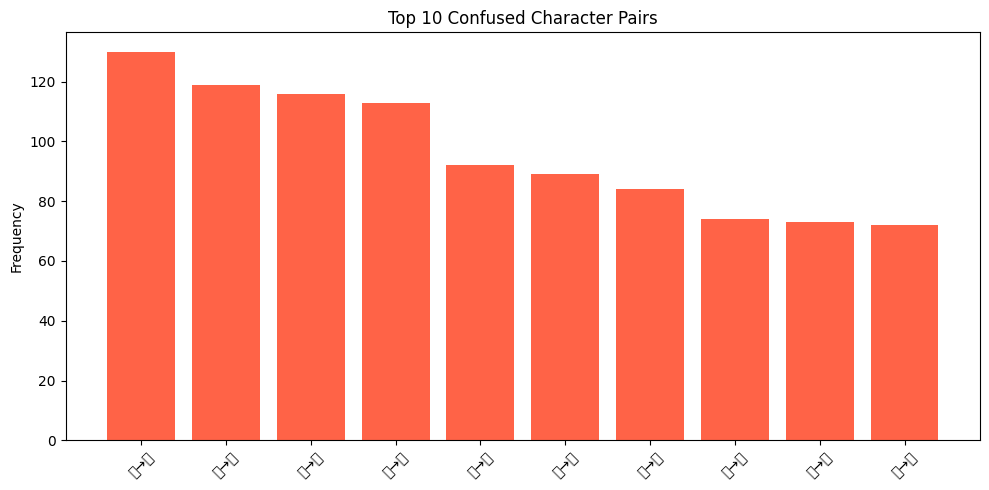

In [26]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set Devanagari-compatible font
plt.rcParams['font.family'] = 'Noto Sans Devanagari'

# --- Hindi vowels and consonants for Devanagari
hindi_vowels = set('अआइईउऊएऐओऔऋॠऌॡॲऑऍ')
# Note: Depending on your data, you may need to expand this set

def is_vowel(ch):
    return ch in hindi_vowels

# Initialize counters
consonant_errors = 0
vowel_errors = 0
long_seq_errors = 0
total_errors = 0
total_long = 0
char_confusions = defaultdict(int)

# Length threshold to consider a sequence as "long"
LONG_THRESHOLD = 7

for src, pred, tgt in all_preds:
    if pred != tgt:
        total_errors += 1

        # Check if long
        if len(tgt) >= LONG_THRESHOLD:
            long_seq_errors += 1
        if len(tgt) >= LONG_THRESHOLD:
            total_long += 1

        # Check char-level mismatches
        for p, t in zip(pred, tgt):
            if p != t:
                if is_vowel(t):
                    vowel_errors += 1
                else:
                    consonant_errors += 1
                char_confusions[(t, p)] += 1

# Total character errors
total_char_errors = vowel_errors + consonant_errors

print("Error Analysis:")
print(f"Total sequence errors: {total_errors}")
print(f"Character-level consonant errors: {consonant_errors} ({(consonant_errors/total_char_errors)*100:.2f}%)")
print(f"Character-level vowel errors: {vowel_errors} ({(vowel_errors/total_char_errors)*100:.2f}%)")
print(f"Errors in long sequences (≥ {LONG_THRESHOLD}): {long_seq_errors} ({(long_seq_errors/total_errors)*100:.2f}%)")

# Top confused character pairs
sorted_confusions = sorted(char_confusions.items(), key=lambda x: -x[1])[:10]
print("\nTop 10 confused character pairs (Target → Predicted):")
for (true_c, pred_c), count in sorted_confusions:
    print(f"{true_c} → {pred_c}: {count} times")

# Optional: bar plot
chars, counts = zip(*sorted_confusions)
labels = [f"{t}→{p}" for (t, p) in chars]

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color="tomato")
plt.title("Top 10 Confused Character Pairs")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
